In [7]:
import os
import time
import torch
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd


from hcnn.model import HarmonicFeatureExtractor, HarmonicFeatureExtractorConfig
from hcnn.utils import visualize_features, visualize_feature_embeddings, summarize_features, dimensionality_reduction
from data.trf.trf_dataset import TRFDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import all_estimators

import audio_separator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = HarmonicFeatureExtractorConfig()
config.sample_rate = 4000
config.n_fft = 256
config.hop_length = 32
config.n_harmonics = 2
config.n_filters_per_semitone = 1
fe = HarmonicFeatureExtractor(config=config)

In [3]:
seq_len_s = 30
sample_rate = 4000
ds = TRFDataset('./data/trf/1/thaat', seq_len_s, sample_rate)
print(len(ds))
ds[0]

952


(tensor([-0.2293, -0.2637, -0.3263,  ..., -0.0549, -0.1514, -0.0300]), 0)

In [4]:
x, label = ds[0]
print(ds.idx_to_label[label])
ipd.Audio(x, rate=ds.sample_rate)

Bhairav (thaat)


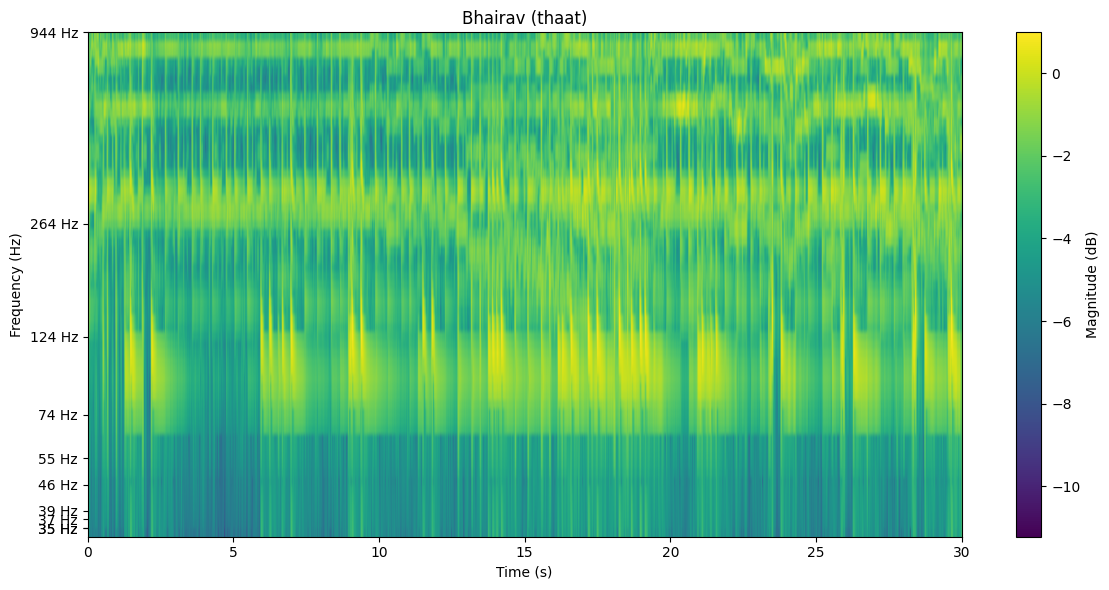

torch.Size([59, 3751])


In [5]:
features = fe(x).detach()
visualize_features(features, sample_rate=config.sample_rate, hop_length=config.hop_length, center_freqs=fe.center_freqs,
                   title=f'{ds.get_label_name(label)}', figsize=(12, 6))
print(features.shape)

In [23]:
N_examples = 128
idcs = np.random.choice(np.arange(len(ds)), size=N_examples, replace=False)
F, L = [], []
for i in tqdm(idcs):
    x, label = ds[i]
    features = fe(x).detach()
    F.append(features)
    L.append(label)
F = torch.cat(F, dim=0)
L = torch.tensor(L)

100%|██████████| 128/128 [01:32<00:00,  1.39it/s]


In [7]:
def train_classification_model(X, y, config):
    model_name = config.get("model_name", "RandomForestClassifier")
    model_params = config.get("model_params", {})

    classifiers = dict(all_estimators(type_filter='classifier'))
    if model_name not in classifiers:
        raise ValueError(f"Model '{model_name}' is not a valid scikit-learn classifier.")

    model_cls = classifiers[model_name]
    model = model_cls(**model_params)

    print(model)
    model.fit(X, y)

    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", report)
    
    return model, report

In [8]:
X = F
y = L
X = summarize_features(X, 32, 32, 'mean')
N = X.shape[0]
X = X.reshape(N, -1)
X = dimensionality_reduction('PCA', X, n_components=32, features_flat=X, random_sate=42)
print(X.shape)

_, D = X.shape
C = np.unique(y).shape
config = {
    "model_name": "MLPClassifier",
    "model_params": {
        'hidden_layer_sizes': (32, 32, 16, 16),
    },
}

train_classification_model(X, y, config)

(128, 32)
MLPClassifier(hidden_layer_sizes=(32, 32, 16, 16))
Accuracy: 0.8828
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.96      0.96      0.96        26
           2       0.76      0.89      0.82        18
           3       0.88      0.78      0.82         9
           4       0.92      1.00      0.96        12
           5       0.91      0.91      0.91        11
           6       0.92      0.92      0.92        13
           7       0.91      0.91      0.91        11
           8       0.62      1.00      0.77         5
           9       1.00      0.70      0.82        10

    accuracy                           0.88       128
   macro avg       0.88      0.88      0.87       128
weighted avg       0.89      0.88      0.88       128



/Users/advaitkoparkar/Documents/projects/music_tagging/.music_tagging_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(MLPClassifier(hidden_layer_sizes=(32, 32, 16, 16)),
 '              precision    recall  f1-score   support\n\n           0       0.90      0.69      0.78        13\n           1       0.96      0.96      0.96        26\n           2       0.76      0.89      0.82        18\n           3       0.88      0.78      0.82         9\n           4       0.92      1.00      0.96        12\n           5       0.91      0.91      0.91        11\n           6       0.92      0.92      0.92        13\n           7       0.91      0.91      0.91        11\n           8       0.62      1.00      0.77         5\n           9       1.00      0.70      0.82        10\n\n    accuracy                           0.88       128\n   macro avg       0.88      0.88      0.87       128\nweighted avg       0.89      0.88      0.88       128\n')

(7680, 2)


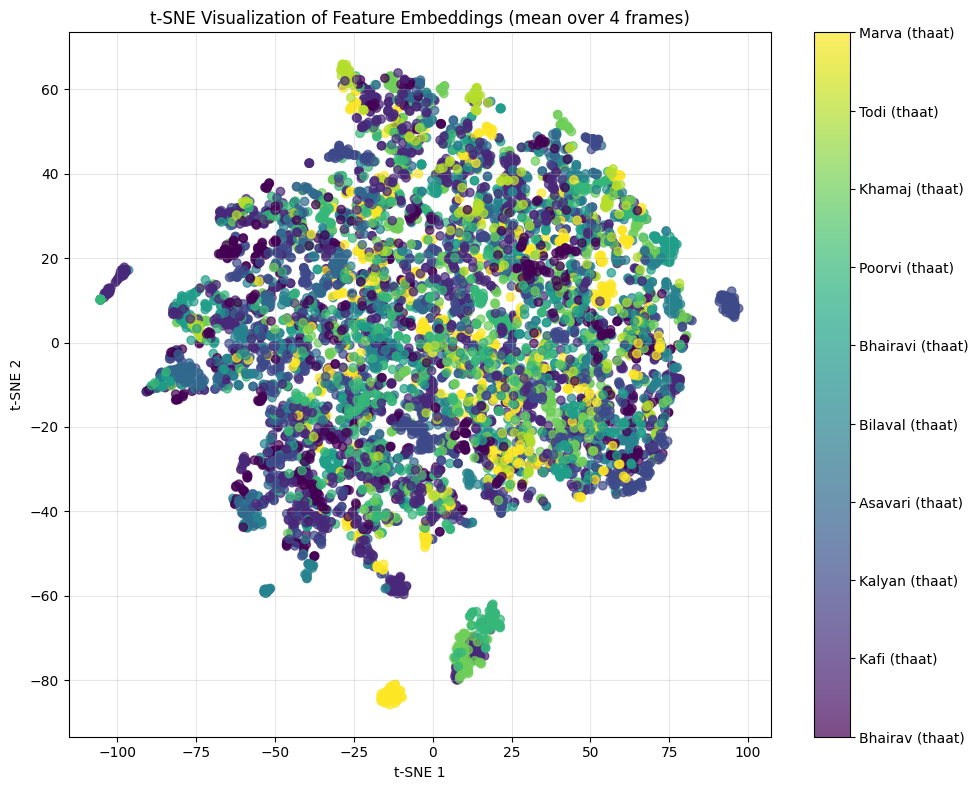

In [10]:
visualize_feature_embeddings(F, L, ds.get_label_names(), method='tsne', n_components=2, window_size=4, mode='mean')

In [15]:
def mmss_to_seconds(time_str):
    try:
        # Parse the time string into a time structure
        time_struct = time.strptime(time_str, "%M:%S")
        
        # Convert minutes and seconds into total seconds
        total_seconds = time_struct.tm_min * 60 + time_struct.tm_sec
        return total_seconds
    except ValueError:
        print("Invalid time format. Please use MM:SS.")
        return None
    
def download_and_crop(url, start, end):
    yt_dlp = "./yt-dlp_macos "
    command = f'{yt_dlp} -x -q --audio-quality 0 --audio-format wav "{url}" -o tmp.wav'
    os.system(command)

    fs = 4000
    wav, _fs = librosa.load("./tmp.wav", mono=True)
    os.remove("./tmp.wav")
    wav = librosa.resample(wav, orig_sr=_fs, target_sr=fs)

    if start is None:
        start = 0
    else:
        start = int(mmss_to_seconds(start)*fs)
    if end is None:
        end = -1
    else:
        end = int(mmss_to_seconds(end) * fs)
    wav = wav[start:end, None]

    max_amp = np.percentile(np.abs(wav), 100)
    wav = np.clip(wav, -max_amp, max_amp)
    wav /= max_amp
    wav *= 0.9

    return wav, fs

In [22]:
url = r'https://www.youtube.com/watch?v=OX6Da7jmYP8&ab_channel=MusicToday'
wav, fs = download_and_crop(url, '01:30', '2:00')
sf.write('music.wav', wav, samplerate=fs)

In [24]:
import audio_separator.separator as separator
wav, fs = sf.read('music.wav')
sep = separator.Separator()
sep.load_model()
sep.separate('music.wav', {'Vocals': 'vocal', 'Instrumental': 'instrumental'})

2025-05-01 18:52:55,083 - INFO - separator - Separator version 0.31.0 instantiating with output_dir: None, output_format: WAV
2025-05-01 18:52:55,083 - INFO - separator - Output directory not specified. Using current working directory.
2025-05-01 18:52:55,083 - INFO - separator - Using model directory from model_file_dir parameter: /tmp/audio-separator-models/
2025-05-01 18:52:55,084 - INFO - separator - Operating System: Darwin Darwin Kernel Version 22.3.0: Mon Jan 30 20:38:43 PST 2023; root:xnu-8792.81.3~2/RELEASE_ARM64_T8112
2025-05-01 18:52:55,084 - INFO - separator - System: Darwin Node: Advaits-Air.hsd1.ca.comcast.net Release: 22.3.0 Machine: arm64 Proc: arm
2025-05-01 18:52:55,084 - INFO - separator - Python Version: 3.11.4
2025-05-01 18:52:55,084 - INFO - separator - PyTorch Version: 2.6.0
2025-05-01 18:52:55,218 - INFO - separator - FFmpeg installed: ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
2025-05-01 18:52:55,220 - INFO - separator - ONNX Runtime CPU

['instrumental.wav', 'vocal.wav']

In [ ]:
wav, fs = sf.read('vocal.wav')
config = HarmonicFeatureExtractorConfig()
config.sample_rate = fs
config.n_fft = 256
config.hop_length = 32
config.n_harmonics = 1
config.n_filters_per_semitone = 1
fe = HarmonicFeatureExtractor(config=config)

features = fe(torch.tensor(wav.reshape(1, -1))).detach()
visualize_features(features, sample_rate=config.sample_rate, hop_length=config.hop_length, center_freqs=fe.center_freqs,
                   figsize=(12, 6))